# Trabajo Extra Capítulo 4

En este cuaderno voy a aplicar los algoritmos utilizados en la practica anterior con una imágen diferente. Mi objetivo aplicar la correlación de keypoints entre 2 imágenes diferentes.

Las imagenes han sido extraídas de la carpeta de imágenes.

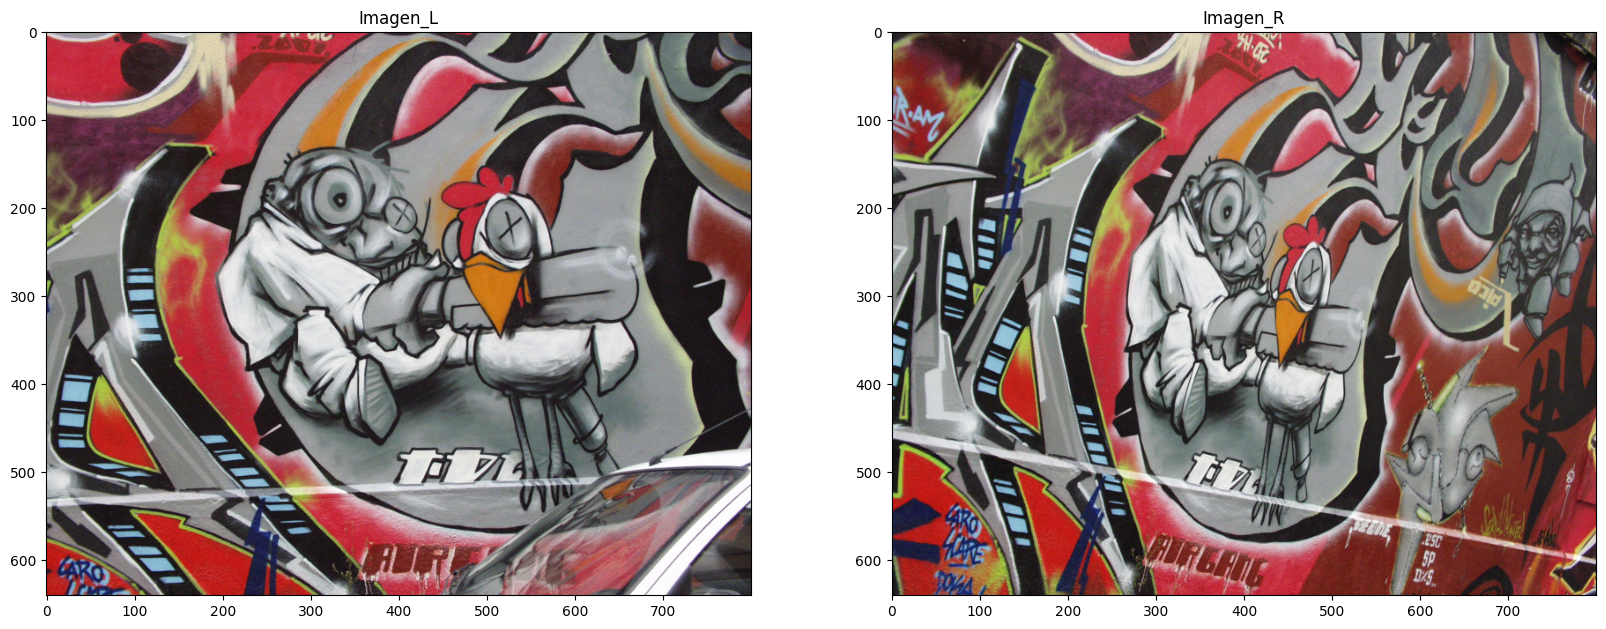

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
images_path = './images/'

image_l = cv2.imread(images_path + 'pov1.png')
image_l = cv2.cvtColor(image_l,cv2.COLOR_BGR2RGB)

image_r = cv2.imread(images_path + 'pov2.png')
image_r = cv2.cvtColor(image_r,cv2.COLOR_BGR2RGB)

# Show it
plt.subplot(121)
plt.title("Imagen_L")
plt.imshow(image_l);

plt.subplot(122)
plt.title("Imagen_R")
plt.imshow(image_r);

#### <font color="Blue">Para lograr la correlación cruzada debemos seguir una serie de pasos:</font>

### **<span style="color:green"><b><i>1.- Obtención de keypoints - Harris</i></b></span>**

Con el detector de Harris podemos obtener los keypoints asociados a cada imagen:

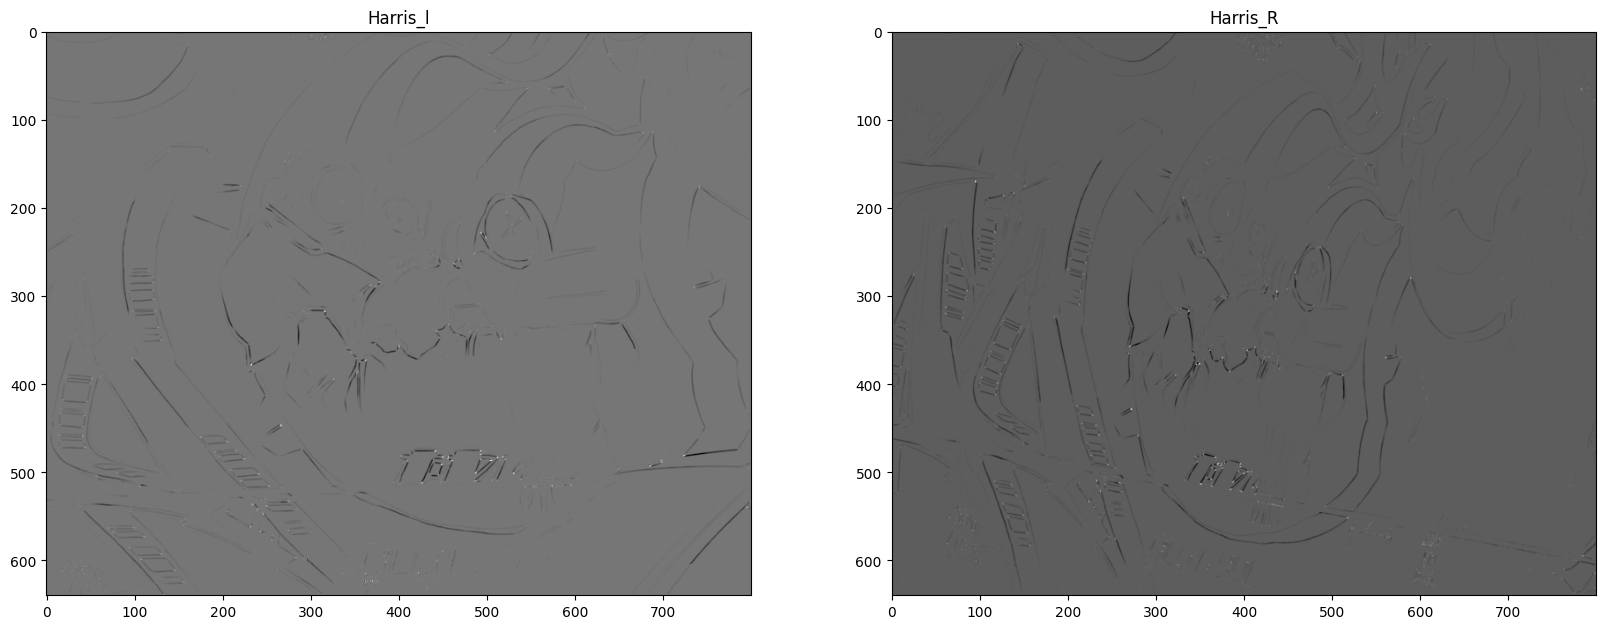

In [2]:
# Size of Sobel kernel
size_sobel = 3

# Size of Gaussian window (in openCV neighbor averaging)
size_window = 2

# Empiric constant K
const_k = 0.04

# Get gray images
image_l_gray = cv2.cvtColor(image_l, cv2.COLOR_RGB2GRAY)
image_r_gray = cv2.cvtColor(image_r, cv2.COLOR_RGB2GRAY)

# Compute corners
harris_l = cv2.cornerHarris(image_l_gray, size_window, size_sobel, const_k)
harris_r = cv2.cornerHarris(image_r_gray, size_window, size_sobel, const_k)

# Show it
plt.subplot(121)
plt.title("Harris_l")
plt.imshow(harris_l,cmap='grey');

plt.subplot(122)
plt.title("Harris_R")
plt.imshow(harris_r,cmap='grey');

### **<span style="color:green"><b><i>2.- Aplicar thresholding y supresion no máxima</i></b></span>**

Una vez ya hemos obtenido la imagen de harris, es importante asegurarnos de que los keypoints que hemos detectado son correctos. Esto lo solventamos con el thresholding.

La supresión no máxima, a su vez, nos ayuda a escoger los mejores keypoints eliminando la respuesta múltiple.

In [3]:
#FUNCION IMPORTADA
from scipy import signal
def nonmaxsuppts(cim, radius, thresh):
    """ Binarize and apply non-maximum suppresion.   
    
        Args:
            cim: the harris 'R' image
            radius: the aperture size of local maxima window
            thresh: the threshold value for binarization
                    
        Returns: 
            r, c: two numpy vectors being the row (r) and the column (c) of each keypoint
    """   
    
    rows, cols = np.shape(cim)
    sze = 2 * radius + 1
    mx = signal.order_filter(cim, np.ones([sze, sze]), sze ** 2 - 1)
    bordermask = np.zeros([rows, cols]);
    bordermask[radius:(rows - radius), radius:(cols - radius)] = 1
    cim = np.array(cim)
    r, c = np.where((cim == mx) & (cim > thresh) & (bordermask == 1))
    return r, c

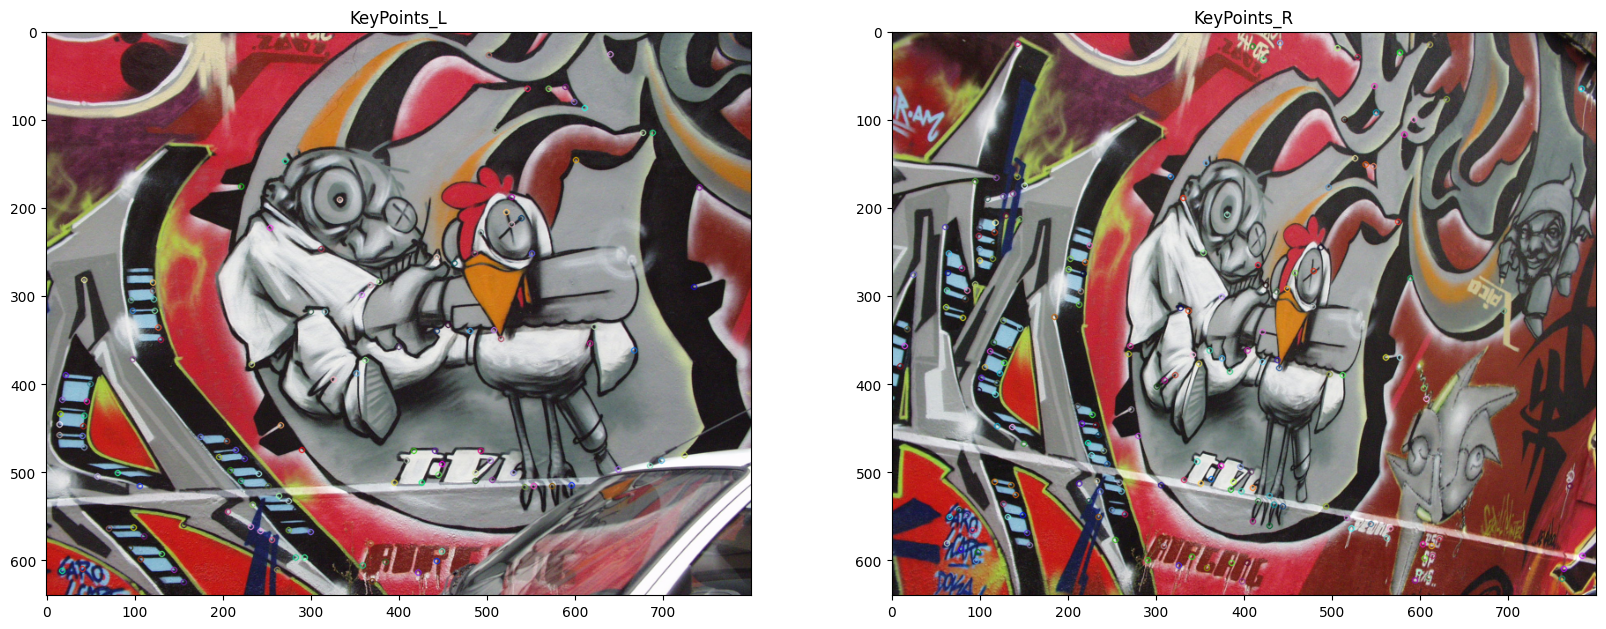

In [4]:
# For non-max-supp
radius_non_maxima = 8

# Apply non maximum supression
r_l,c_l = nonmaxsuppts(harris_l, radius_non_maxima, 0.1*harris_l.max())
r_r,c_r = nonmaxsuppts(harris_r, radius_non_maxima, 0.1*harris_r.max())

# Convert coordinates to cv2.KeyPoint list
kps_l = [cv2.KeyPoint(int(c_l[i]), int(r_l[i]), radius_non_maxima) for i in range(len(r_l))]
kps_r = [cv2.KeyPoint(int(c_r[i]), int(r_r[i]), radius_non_maxima) for i in range(len(r_r))]

image_l_nms = np.copy(image_l)
cv2.drawKeypoints(image_l_nms, kps_l, image_l_nms)

image_r_nms = np.copy(image_r)
cv2.drawKeypoints(image_r_nms, kps_r, image_r_nms)

# Show it
plt.subplot(121)
plt.title("KeyPoints_L")
plt.imshow(image_l_nms);

plt.subplot(122)
plt.title("KeyPoints_R")
plt.imshow(image_r_nms);

### **<span style="color:green"><b><i>3.- Correlación cruzada mediante NCC</i></b></span>**

En el último paso, una vez obtenidos los KeyPoints de cada imagen, solo debemos relacionarlo mediante NCC.

Para aplicar este método, debemos iterar por el array de keypoints de la imagen de la izquierda, seleccionando una ventana para formar una template. Esta template nos servirá para aplicar el NCC.

El ncc nos devuelve una imagen resultante de hacer la comparación de esa template con cada uno de los píxeles de la imagen derecha.
De esta forma, si el valor de NCC en alguno de los KeyPoints de la imagen de la derecha es muy cercano a 1 en un punto, sabremos que se relaciona con él.

C:\Users\adrid\AppData\Local\Temp\ipykernel_20116\142347778.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matches = [cv2.DMatch(matches[i,0], int(matches[i,1]),1) for i in range(matches.shape[0])]


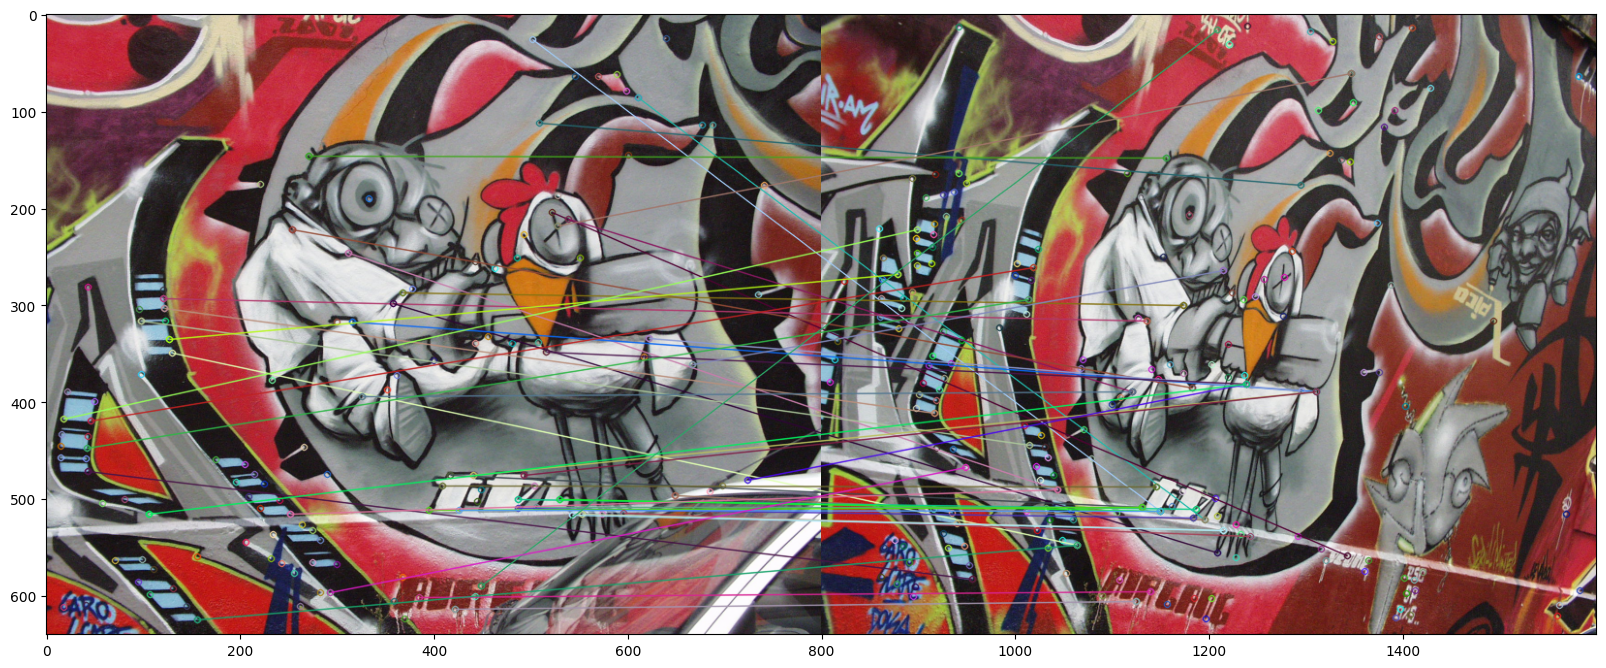

In [5]:
# Aperture size of the NCC window
w_temp = 10

# Apply border reflect padding to images
image_l_pad = cv2.copyMakeBorder(image_l, w_temp, w_temp, w_temp, w_temp, cv2.BORDER_REFLECT)
image_r_pad = cv2.copyMakeBorder(image_r, w_temp, w_temp, w_temp, w_temp, cv2.BORDER_REFLECT)

# Initialize matches list
matches = []

# For each keypoint in left image
for p_index in range(len(r_l)):
    
    # 1. Get the template (note the w_temp offset because of the padding in previous step)
    p_r, p_c = r_l[p_index]+w_temp, c_l[p_index]+w_temp
    template = image_l_pad[p_r-w_temp:p_r+w_temp+1,p_c-w_temp:p_c+w_temp+1]
    
    # 2. Compute NCC of the left keypoint in right image
    ncc = cv2.matchTemplate(image_r_pad, template, cv2.TM_CCORR_NORMED)

    # 3. Find max value in NCC (only at the right keypoints)
    max_value = np.amax(ncc[r_r,c_r])
    
    # 4. If match is good
    if max_value > 0.925:
        # Include in match list
        [max_index] = np.where(ncc[r_r,c_r] == max_value)
        matches.append((p_index, max_index))

# Cast matches list to cv2.DMatch list
matches = np.asarray(matches,dtype=object)
matches = [cv2.DMatch(matches[i,0], int(matches[i,1]),1) for i in range(matches.shape[0])]

# Draw matches
image_matches = np.copy(image_l)
image_matches = cv2.drawMatches(image_l,kps_l,image_r,kps_r,matches,image_matches)

# And show them
plt.imshow(image_matches);

Vemos que el resultado está lejos de ser perfecto. Para llegar a esta solución he tenido que ir probando diferentes combinaciones de parámetros:

-En cuanto al radio de la supresión no máxima, he decido coger uno grande para eliminar lo máximo posible el exceso de keypoints innecesarios en una zona.

-El tamaño de la ventana de la template ha sido de 10. Cogiendo una ventana tan pequeña, hay algunos puntos que no termina relacionar correctamente. Se puede deber a que la diferencia de ángulo entre las 2 imágenes es considerable.

-Por último el threshold para determinar si un match es correcto, he decidido ser más permisivo, cogiendo un threshold de 0.925. Si aumentamos el threshold, es bastante más estricto, apareciendo muy pocos matches.

Aquí concluye mi trabajo extra de este capítulo. Me han fascinado los conceptos utilizados en cada uno de los pasos hasta llegar a la solución final, pues nos dan un resultado realmente gráfico de lo que estamos haciendo.